## TRANSFER LEARNING: IMPROVING ALGORITHM
---

### Libraries

In [26]:
import pickle
import os

#basic
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#tensorflow and keras
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten, MaxPooling2D, Dropout, Resizing, Rescaling, RandomBrightness, RandomContrast, RandomCrop, RandomFlip, RandomRotation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Model
from keras.utils import load_img, img_to_array
from keras.models import load_model

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

#open cv
import cv2 as cv


from cascid.configs import config, pad_ufes
from cascid import database

# Local py script
from model import *

In [57]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Greens, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (16,16))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig('Assets/files/' + title + '.pdf')
    return ax

### Constants

In [8]:
# PATH = "/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/data/"
RANDOM_STATE = 42
TRAIN_SIZE = 0.7
VALIDATION_SIZE = 0.15
TEST_SIZE = 0.15
EPOCHS = 3000
IMAGE_SHAPE = (128, 128, 3)

FERNANDO_PATH = config.DATA_DIR / 'experiments' / 'fernando'
FERNANDO_PATH.mkdir(exist_ok=True, parents=True)

IMAGE_CACHE = FERNANDO_PATH / 'img_cache.pkl'
FEATURES_FILE = FERNANDO_PATH / 'features.pkl'
MODEL_PATH = FERNANDO_PATH / 'models' / 'deep_learning'

COMPUTE_FEATURES = False
FORCE_IMAGE_CACHE = False
TRAIN_MODEL = False


### Loading data

In [9]:
df = database.get_db()
df.head(5).transpose()

,0,1,2,3,4
patient_id,PAT_1516,PAT_46,PAT_1545,PAT_1989,PAT_684
lesion_id,1765,881,1867,4061,1302
smoke,NaN,False,NaN,NaN,False
drink,NaN,False,NaN,NaN,True
background_father,NaN,POMERANIA,NaN,NaN,POMERANIA
background_mother,NaN,POMERANIA,NaN,NaN,POMERANIA
age,8,55,77,75,79
pesticide,NaN,False,NaN,NaN,False
gender,NaN,FEMALE,NaN,NaN,MALE
skin_cancer_history,NaN,True,NaN,NaN,True


### Split train, validation and test

In [10]:
MulticlassEncoder = OneHotEncoder(sparse=False)
Y = MulticlassEncoder.fit_transform(df[["diagnostic"]].to_numpy())
x_train, x_test, y_train, y_test = train_test_split(df["img_id"].to_numpy(), Y, test_size=0.2, random_state=RANDOM_STATE)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

print("x_train shape: {0}".format(x_train.shape))
print("x_validation shape: {0}".format(x_valid.shape))
print("x_test shape: {0}".format(x_test.shape))

print("y_train shape: {0}".format(y_train.shape))
print("y_validation shape: {0}".format(y_valid.shape))
print("y_test shape: {0}".format(y_test.shape))

x_train shape: (1470,)
x_validation shape: (368,)
x_test shape: (460,)
y_train shape: (1470, 6)
y_validation shape: (368, 6)
y_test shape: (460, 6)


### Image Test

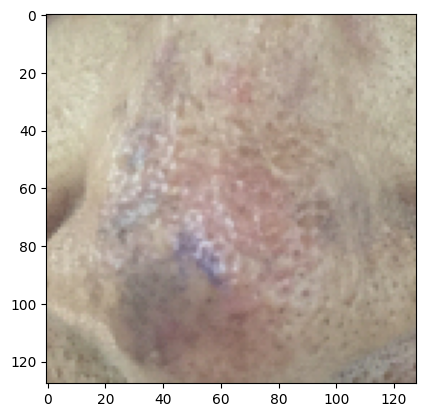

In [11]:
def load_image(name: str):
    pil_img = load_img(
        str(pad_ufes.IMAGES_DIR / name),
        grayscale=False,
        color_mode='rgb',
        target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
        interpolation='nearest',
        keep_aspect_ratio=False
    )

    return img_to_array(pil_img, dtype=np.uint8)

plt.imshow(load_image(x_train[7]))
plt.show()

### Image Loading and cache

In [12]:
# Automatic caching of image read operations (slow)
if not os.path.exists(IMAGE_CACHE) or FORCE_IMAGE_CACHE:
    print("Cache not found, doing read operations...")
    reader = lambda img_path_list : np.array(list(map(load_image, img_path_list)))
    image_dict = {
        "train": reader(x_train),
        "test": reader(x_test),
        "valid": reader(x_valid)
    }
    with open(IMAGE_CACHE, 'wb') as file:
        pickle.dump(image_dict, file)
    print("Read operations done, cache file available at {}".format(IMAGE_CACHE))
else:
    with open(IMAGE_CACHE, 'rb') as file:
        image_dict = pickle.load(file)

# Return to original variables
x_train = image_dict["train"]
x_test = image_dict["test"]
x_valid = image_dict["valid"]

### Data augmentation

In [13]:
# train_data_augmentation_generator = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
# )

input_layer = keras.Sequential([
    Rescaling(1./255), # Rescale from 0 to 255 UINT8 to 0 to 1 float.
])

augmentor = keras.Sequential([
    RandomBrightness(factor=(-0.3, 0.3), value_range=(0.0, 1.0), seed=RANDOM_STATE), # Randomly change brightness anywhere from -30% to +30%
    RandomContrast(factor=0.5, seed=RANDOM_STATE), # Randomly change contrast anywhere from -30% to +30%
    RandomFlip(mode="horizontal_and_vertical", seed=RANDOM_STATE), # Randomly flip images either horizontally, vertically or both
    RandomRotation(factor=(-0.3, 0.3), fill_mode="nearest", interpolation="bilinear", seed=RANDOM_STATE), # Randomly rotate anywhere from -30% * 2PI to +30% * 2PI, filling gaps by using 'nearest' strategy
])

### Model

In [14]:
if COMPUTE_FEATURES:
    resnet = keras.applications.ResNet50(
        weights='imagenet',
        input_shape=IMAGE_SHAPE,
        pooling='avg',
        include_top=False,
    )
    resnet.trainable = False  #to make sure it's not being trained
    # Augmentation only on training
    feature_extractor_train = keras.Sequential([
        input_layer,
        augmentor,
        resnet
    ])
    # Test/Validation only get rescaled
    feature_extractor_test_valid = keras.Sequential([
        input_layer,
        resnet
    ])
    features_train = feature_extractor_train(x_train)
    features_valid = feature_extractor_test_valid(x_valid)
    features_test = feature_extractor_test_valid(x_test)

    features = {
        "train": features_train.numpy(),
        "test": features_test.numpy(),
        "valid": features_valid.numpy(),
        "y_train": y_train,
        "y_test": y_test,
        "y_valid": y_valid,
    }

    with open(FEATURES_FILE, 'wb') as file:
        pickle.dump(features, file)
else:
    with open(FEATURES_FILE, 'rb') as file:
        features = pickle.load(file)

x_train = features["train"]
x_test = features["test"]
x_valid = features["valid"]
y_train = features["y_train"]
y_test = features["y_test"]
y_valid = features["y_valid"]

In [15]:
print(f'{features["train"].shape=}\n{features["test"].shape=}\n{features["valid"].shape=}')

features["train"].shape=(1470, 2048)
features["test"].shape=(460, 2048)
features["valid"].shape=(368, 2048)


In [32]:
test_series = pd.Series(MulticlassEncoder.inverse_transform(y_test).T[0]).value_counts(normalize=True)
train_series = pd.Series(MulticlassEncoder.inverse_transform(y_train).T[0]).value_counts(normalize=True)
valid_series = pd.Series(MulticlassEncoder.inverse_transform(y_valid).T[0]).value_counts(normalize=True)
print("Class distribution in segments:")
class_distro_df = pd.DataFrame({
    "Train": train_series,
    "Test": test_series,
    "Validation": valid_series,
})
classes = class_distro_df.index.to_list()
class_distro_df

Class distribution in segments:


,Train,Test,Validation
ACK,0.324490,0.289130,0.326087
BCC,0.368027,0.384783,0.345109
MEL,0.020408,0.028261,0.024457
NEV,0.104762,0.108696,0.108696
SCC,0.073469,0.095652,0.108696
SEK,0.108844,0.093478,0.086957


In [17]:
model = keras.Sequential([
    Input(shape = features["train"].shape[1]),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(128),
    Dropout(0.1),
    Dense(64),
    Dropout(0.1),
    Dense(y_train.shape[1], activation='softmax')
])

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                

### Train

In [20]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    patience=100,
    restore_best_weights=True
)


In [22]:
if TRAIN_MODEL:
    print(f"Variable {TRAIN_MODEL=}, model training initiated...")
    training_history = model.fit(
        features["train"],
        y_train,
        epochs=EPOCHS,
        validation_split=0.2,
        batch_size=512,
        callbacks=[early_stopping]
    )

    model.save(MODEL_PATH)

    with open(MODEL_PATH / 'history.pkl', 'wb') as fl:
        pickle.dump(training_history.history, fl)
    training_history = training_history.history

else:
    model = keras.models.load_model(MODEL_PATH)
    with open(MODEL_PATH / 'history.pkl', 'rb') as fl:
        training_history = pickle.load(fl)

    print("Loaded model from cache")



EOFError: Ran out of input

In [ ]:
pd.DataFrame(training_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy (loss)")
plt.ylim((0,10))
plt.title("Model History")
plt.show()


### Evaluating the model

In [23]:
model = load_model(MODEL_PATH)

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                

15/15 [==============================] - 0s 2ms/step


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

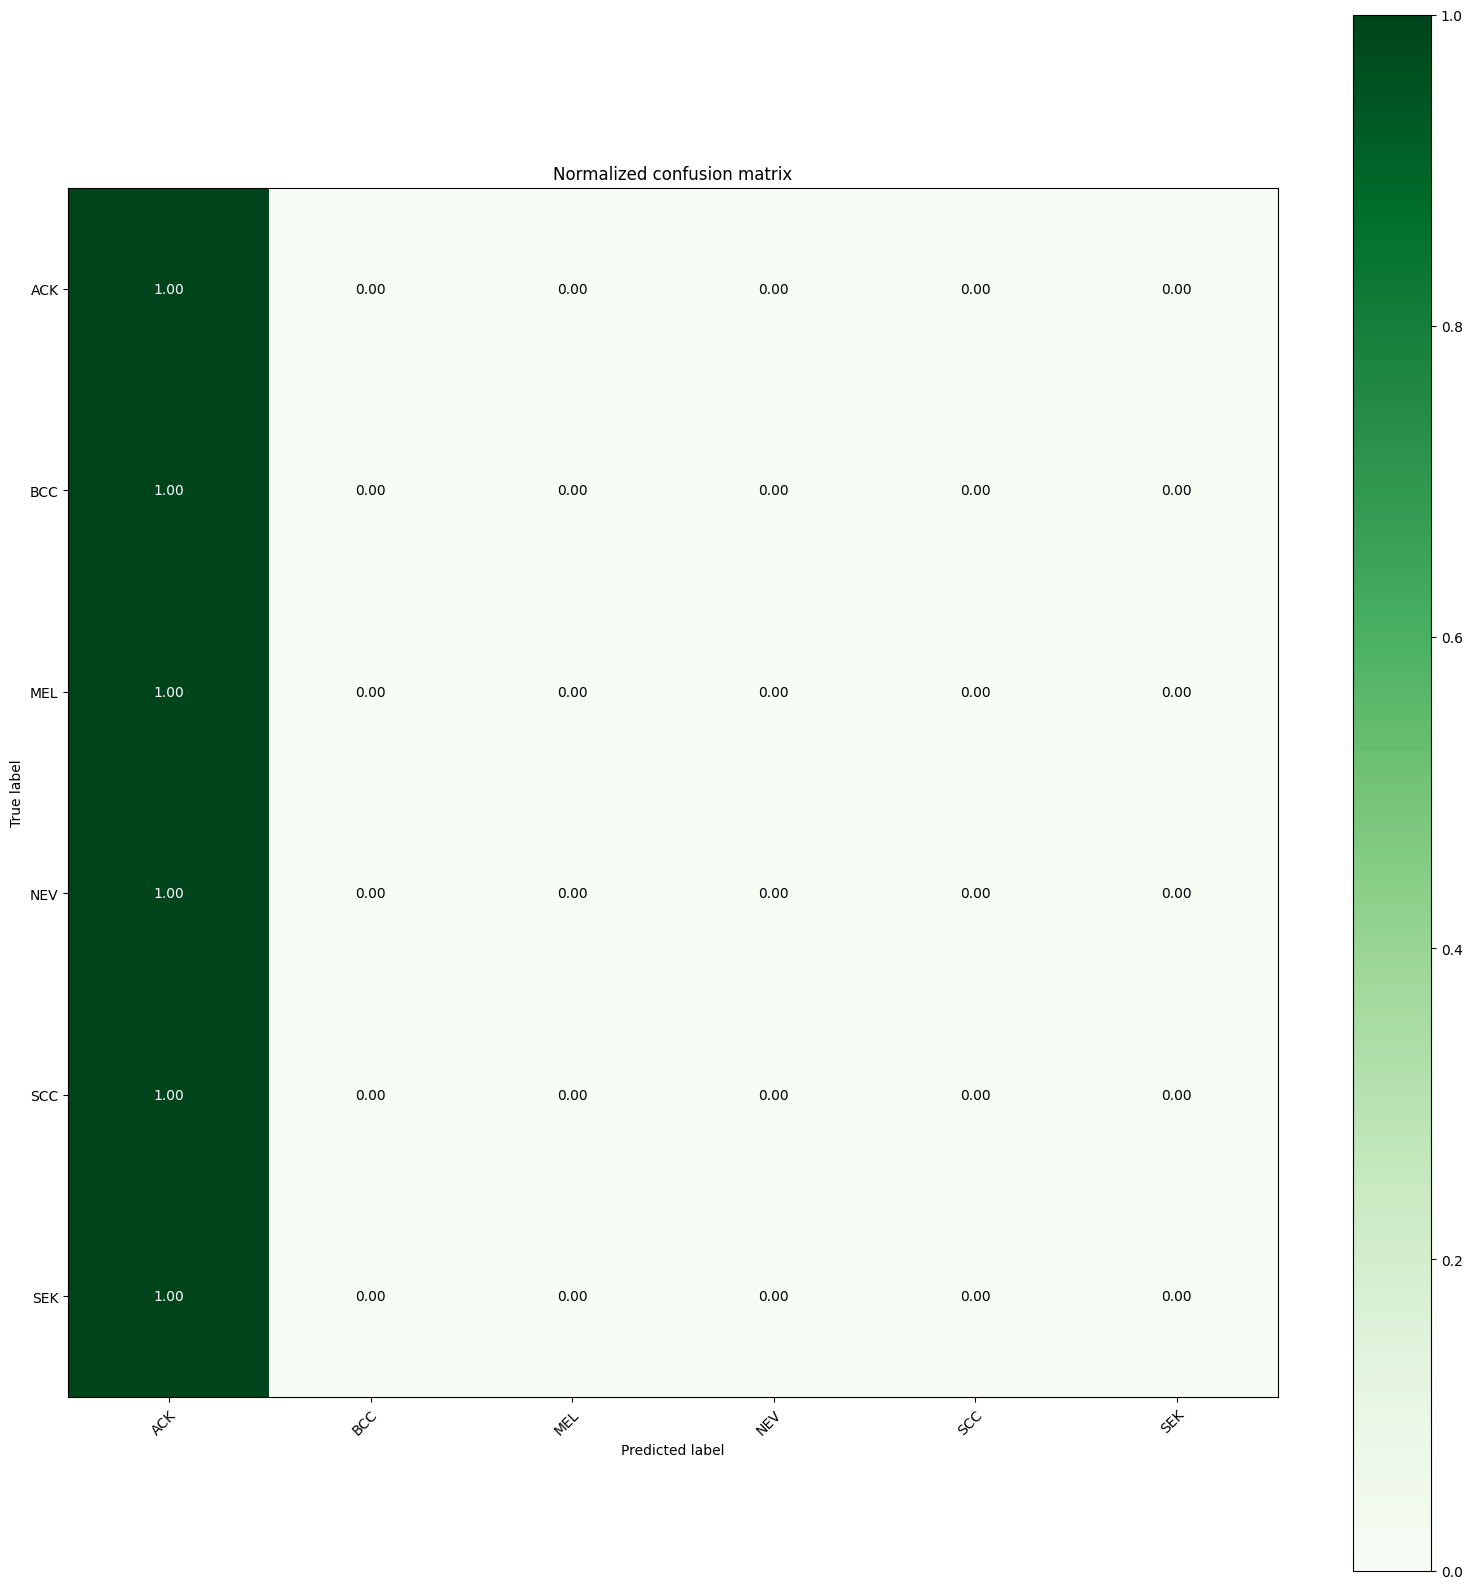

In [58]:
y_pred_proba = model.predict(x_test)
plot_confusion_matrix(MulticlassEncoder.inverse_transform(y_test), MulticlassEncoder.inverse_transform(y_pred_proba), classes)

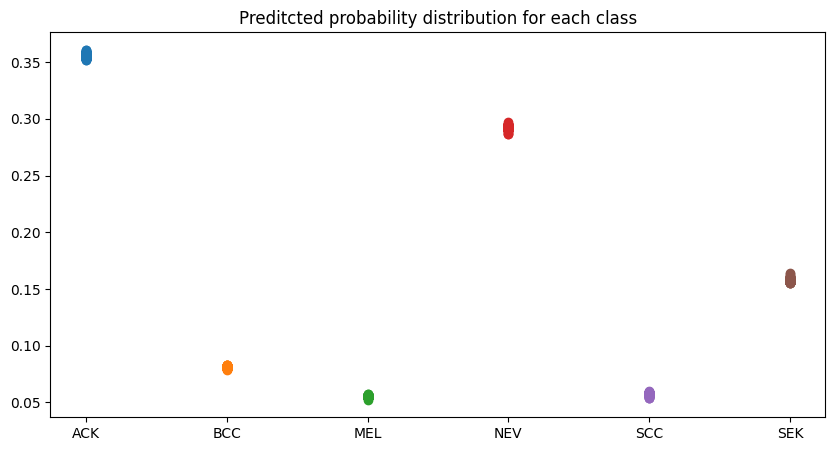

In [64]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
n_classes = len(classes)
for i in range(n_classes):
    ax.scatter([0.5*i for j in range(y_pred_proba.shape[0])], y_pred_proba[:,i])
ax.set_xticks([0.5*j for j in range(n_classes)])
ax.set_xticklabels(classes)
ax.set_title("Preditcted probability distribution for each class")
fig.show()